# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=a470eed04828cd750bc9ebb6601122a377de23d70399c124d736f63af04c5b34
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=8d6df85bc209e1d357c8b54107e716f2f290b077c917c91ba37a875b8b0edc5e
  Stored in directory: /root/.cache/pip/w

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/


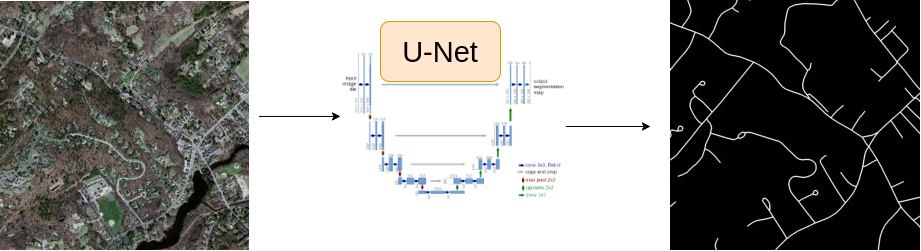

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 37.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [7]:
idx = 4

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path  = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

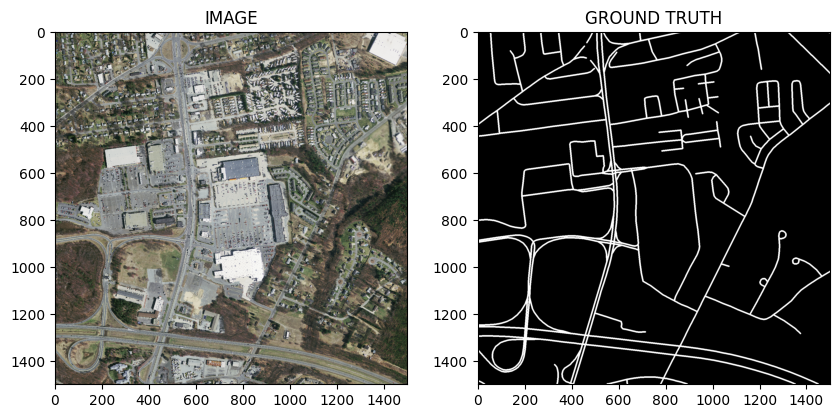

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [10]:
train_df.shape

(159, 2)

In [11]:
valid_df.shape

(40, 2)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_val_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [14]:
from torch.utils.data import Dataset

In [19]:
class segmentationdataset(Dataset):

  def __init__(self, df, augmentation):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    image_path = DATA_DIR + row.images
    mask_path  = DATA_DIR + row.masks
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentation:
      data  = self.augmentation(image = image, mask = mask)
      image = data['image']
      mask  = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask  = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask  = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [20]:
trainset = segmentationdataset(train_df, get_train_augs())
validset = segmentationdataset(valid_df, get_val_augs())

In [21]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


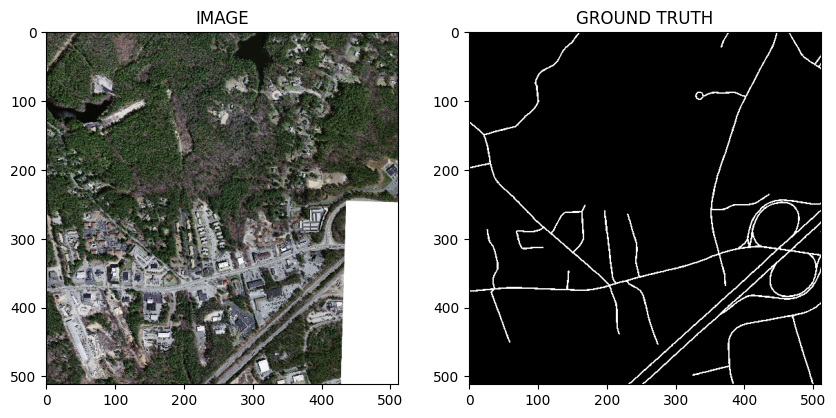

In [23]:
idx = 33

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [24]:
from torch.utils.data import DataLoader

In [25]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [26]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [27]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask  shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask  shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [28]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [29]:
class segmentationmodel(nn.Module):

  def __init__(self):
    super(segmentationmodel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels= 3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [31]:
model = segmentationmodel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [32]:
def train_fn(dataloader, model, optimizer):

  model.train() # Turn On dropout, batchnorm, etc.....

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks  = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [33]:
def eval_fn(dataloader, model):

  model.eval() # Turn Off dropout, batchnorm, etc.....

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      
      images = images.to(DEVICE)
      masks  = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
      
    return total_loss / len(dataloader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [35]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best-model.pt')
    print('SAVED-MODEL')
    best_loss = valid_loss

  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 0.953610610961914 Valid Loss : 0.9183460712432862


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7302113473415375 Valid Loss : 0.7624347448348999


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.677278333902359 Valid Loss : 0.7306989550590515


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6568497747182847 Valid Loss : 0.7225579380989074


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6472466737031937 Valid Loss : 0.71487398147583


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch : 6 Train Loss : 0.6364563584327698 Valid Loss : 0.6710344910621643


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.6248568445444107 Valid Loss : 0.6410942792892456


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch : 8 Train Loss : 0.6376872003078461 Valid Loss : 0.6521859526634216


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 9 Train Loss : 0.612975949048996 Valid Loss : 0.7144053936004638


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 10 Train Loss : 0.6006953865289688 Valid Loss : 0.6761324286460877


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED-MODEL
Epoch : 11 Train Loss : 0.6013333618640899 Valid Loss : 0.6391892552375793


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch : 12 Train Loss : 0.5986462399363518 Valid Loss : 0.6577982306480408


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


SAVED-MODEL
Epoch : 13 Train Loss : 0.6021569758653641 Valid Loss : 0.6385982632637024


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch : 14 Train Loss : 0.5839923471212387 Valid Loss : 0.6890587449073792


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


SAVED-MODEL
Epoch : 15 Train Loss : 0.5884065002202987 Valid Loss : 0.6380216836929321


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch : 16 Train Loss : 0.5797275453805923 Valid Loss : 0.711388885974884


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED-MODEL
Epoch : 17 Train Loss : 0.5769070297479629 Valid Loss : 0.6094154000282288


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 18 Train Loss : 0.5746327698230743 Valid Loss : 0.6485107898712158


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED-MODEL
Epoch : 19 Train Loss : 0.5631129324436188 Valid Loss : 0.6059256076812745


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 20 Train Loss : 0.5633655533194541 Valid Loss : 0.6444558382034302


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 21 Train Loss : 0.5779086396098136 Valid Loss : 0.695572805404663


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 22 Train Loss : 0.5828728765249253 Valid Loss : 0.63667733669281


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 23 Train Loss : 0.5611283242702484 Valid Loss : 0.62421213388443


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 24 Train Loss : 0.5674048289656639 Valid Loss : 0.6156533002853394


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

Epoch : 25 Train Loss : 0.565054140985012 Valid Loss : 0.630910336971283


# Task 9 : Inference

In [36]:
idx = 17

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

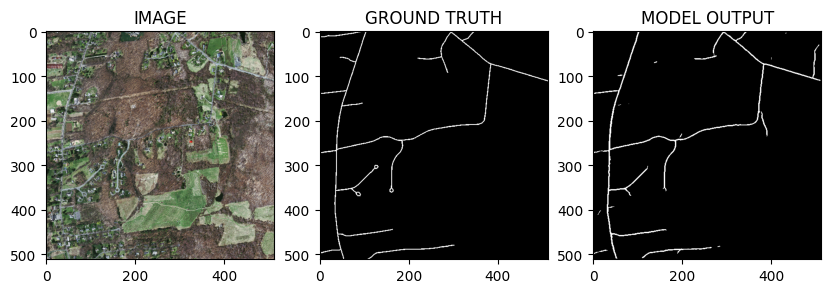

In [37]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [39]:
idx = 5

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

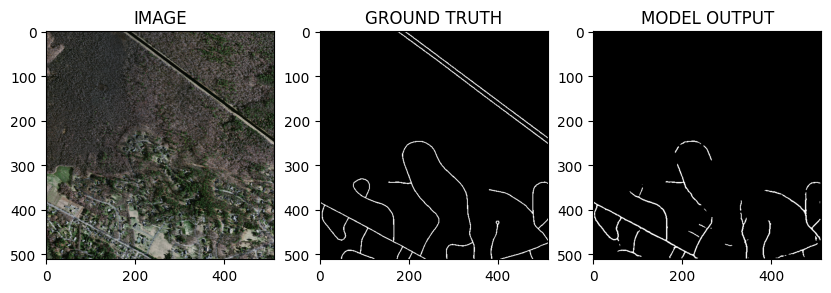

In [40]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [41]:
idx = 30

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

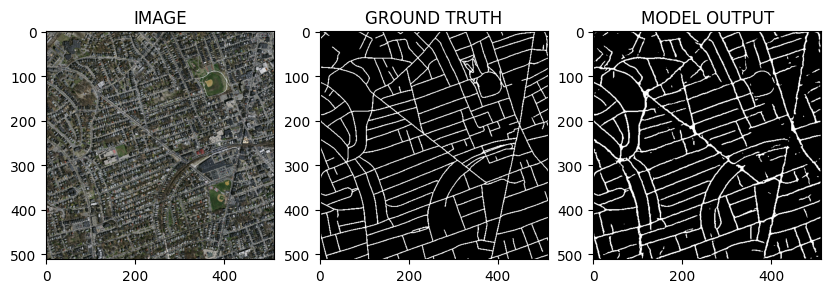

In [42]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))